# ARIMA Model Selection

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.signal import periodogram
import warnings
import pmdarima as pm

from sklearn.metrics import mean_squared_error



# Load the dataset
file_path = "/Users/alonclausen/Desktop/Studie/Kandidat/Seminar/SEMINARFIN/fulldata.csv"
data = pd.read_csv(file_path)

# Display the first few rows to understand the structure
data.head()


,SpotPriceDKK,from,to,temp_pca_1,temp_pca_2,temp_pca_3,wind_speed_pca_1,wind_speed_pca_2,wind_speed_pca_3,wind_speed_pca_4,...,mean_wind_dir_pca_39,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos,oil_price,gas_price,constant
0,596.570007,2024-11-29 23:00:00+00:00,2024-11-30 00:00:00+00:00,-33.480249,7.339981,1.718044,3.248249,2.159318,0.612078,3.505092,...,-0.093112,-0.258819,0.965926,-0.433884,-0.900969,-0.5,0.866025,72.940002,47.811001,1
1,770.270020,2024-11-29 22:00:00+00:00,2024-11-29 23:00:00+00:00,-32.131543,8.173021,2.038769,2.387323,3.215623,0.288633,3.701821,...,-0.004524,-0.500000,0.866025,-0.433884,-0.900969,-0.5,0.866025,72.940002,47.811001,1
2,848.200012,2024-11-29 21:00:00+00:00,2024-11-29 22:00:00+00:00,-30.659681,8.780246,1.967827,1.620036,2.482432,0.516816,3.950176,...,-0.081036,-0.707107,0.707107,-0.433884,-0.900969,-0.5,0.866025,72.940002,47.811001,1
3,836.049988,2024-11-29 20:00:00+00:00,2024-11-29 21:00:00+00:00,-29.321284,9.297498,1.494915,1.490229,2.968878,1.071656,3.674438,...,-0.073105,-0.866025,0.500000,-0.433884,-0.900969,-0.5,0.866025,72.940002,47.811001,1
4,894.219971,2024-11-29 19:00:00+00:00,2024-11-29 20:00:00+00:00,-27.818541,9.207599,0.853380,2.309477,2.890789,0.990981,2.872615,...,-0.040381,-0.965926,0.258819,-0.433884,-0.900969,-0.5,0.866025,72.940002,47.811001,1


## ARIMA Model Parameter Selection

To determine the best parameters for an ARIMA model using only the `SpotPriceDKK` column, we will follow these steps:

1. **Data Preparation**: Extract the `SpotPriceDKK` column and ensure it is in the correct format for time series analysis.
2. **Stationarity Check**: Perform the Augmented Dickey-Fuller (ADF) test to check if the series is stationary.
3. **ACF and PACF Plots**: Plot the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) to identify potential values for the ARIMA parameters (p, d, q).
4. **Model Selection**: Fit ARIMA models with different combinations of parameters and select the best model based on criteria such as AIC (Akaike Information Criterion).

Let's start with the data preparation and stationarity check.
```

In [2]:
# Print the column names to check for the correct datetime column
print(data.columns)

# Ensure 'from' column is in datetime format
data['from'] = pd.to_datetime(data['from'])

# Filter data starting from October 27, 2017
filtered_data = data[data['from'] >= '2017-10-27']

# Split into training and testing sets
training_set = filtered_data[filtered_data['from'] <= '2024-07-31']
testing_set = filtered_data[filtered_data['from'] > '2024-07-31']

# Extract the spot price for training and testing
spot_price_train = training_set['SpotPriceDKK']
spot_price_test = testing_set['SpotPriceDKK']

# Verify the splits
print("Training Set Range:", training_set['from'].min(), "to", training_set['from'].max())
print("Testing Set Range:", testing_set['from'].min(), "to", testing_set['from'].max())

# Set the 'from' column as the index of the spot_price series
spot_price_train.index = training_set['from']
spot_price_test.index = testing_set['from']

# Display the first few rows to verify the changes
spot_price_train.head()

Index(['SpotPriceDKK', 'from', 'to', 'temp_pca_1', 'temp_pca_2', 'temp_pca_3',
       'wind_speed_pca_1', 'wind_speed_pca_2', 'wind_speed_pca_3',
       'wind_speed_pca_4', 'wind_speed_pca_5', 'wind_speed_pca_6',
       'wind_speed_pca_7', 'wind_speed_pca_8', 'wind_speed_pca_9',
       'wind_speed_pca_10', 'wind_speed_pca_11', 'wind_speed_pca_12',
       'wind_speed_pca_13', 'wind_speed_pca_14', 'mean_wind_dir_pca_1',
       'mean_wind_dir_pca_2', 'mean_wind_dir_pca_3', 'mean_wind_dir_pca_4',
       'mean_wind_dir_pca_5', 'mean_wind_dir_pca_6', 'mean_wind_dir_pca_7',
       'mean_wind_dir_pca_8', 'mean_wind_dir_pca_9', 'mean_wind_dir_pca_10',
       'mean_wind_dir_pca_11', 'mean_wind_dir_pca_12', 'mean_wind_dir_pca_13',
       'mean_wind_dir_pca_14', 'mean_wind_dir_pca_15', 'mean_wind_dir_pca_16',
       'mean_wind_dir_pca_17', 'mean_wind_dir_pca_18', 'mean_wind_dir_pca_19',
       'mean_wind_dir_pca_20', 'mean_wind_dir_pca_21', 'mean_wind_dir_pca_22',
       'mean_wind_dir_pca_23', 'm

from
2024-07-31 00:00:00+00:00    635.640015
2024-07-30 23:00:00+00:00    651.309998
2024-07-30 22:00:00+00:00    737.559998
2024-07-30 21:00:00+00:00    739.099976
2024-07-30 20:00:00+00:00    858.049988
Name: SpotPriceDKK, dtype: float64

In [3]:
# Perform the Augmented Dickey-Fuller test
adf_test_diff = adfuller(spot_price_train)

# Extract and display the test results
adf_result_diff = pd.Series(adf_test_diff[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_test_diff[4].items():
    adf_result_diff[f'Critical Value ({key})'] = value

print(adf_result_diff)

Test Statistic                -8.326024e+00
p-value                        3.468878e-13
#Lags Used                     6.000000e+01
Number of Observations Used    5.919600e+04
Critical Value (1%)           -3.430460e+00
Critical Value (5%)           -2.861589e+00
Critical Value (10%)          -2.566796e+00
dtype: float64


In [4]:
# Take first difference of the spot price series
spot_price_diff = spot_price_train.diff().dropna()

# Perform the Augmented Dickey-Fuller test
adf_test_diff = adfuller(spot_price_diff)

# Extract and display the test results
adf_result_diff = pd.Series(adf_test_diff[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_test_diff[4].items():
    adf_result_diff[f'Critical Value ({key})'] = value

print(adf_result_diff)


Test Statistic                   -41.167102
p-value                            0.000000
#Lags Used                        60.000000
Number of Observations Used    59195.000000
Critical Value (1%)               -3.430460
Critical Value (5%)               -2.861589
Critical Value (10%)              -2.566796
dtype: float64


#### We can see that our data is already stationary and there is no reason to differentiate further

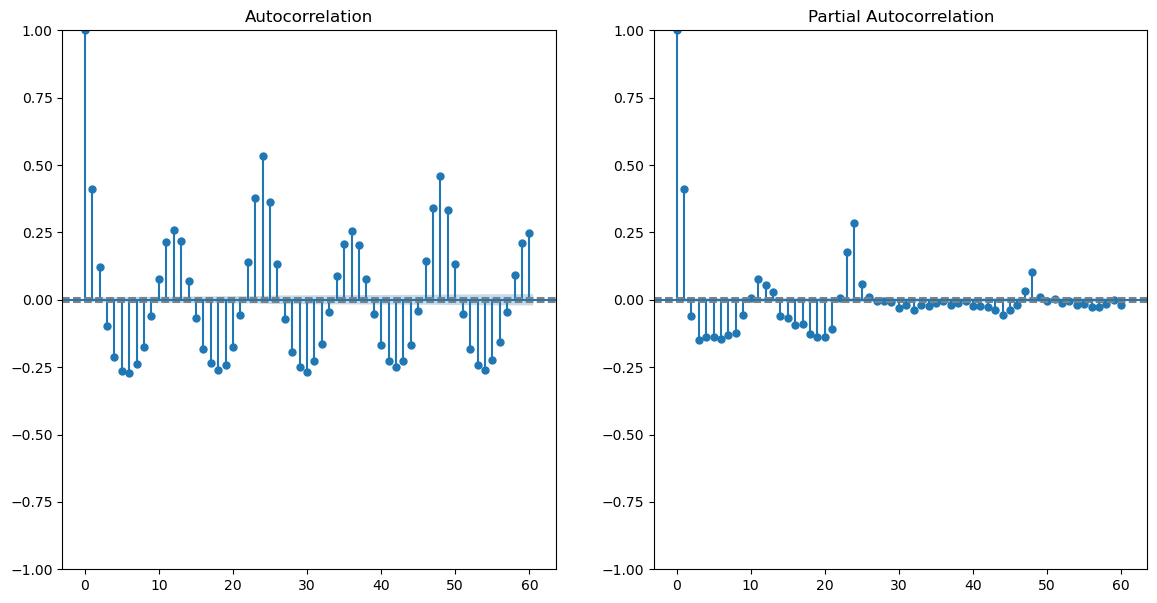

In [5]:
# Calculate the confidence intervals for ACF and PACF
conf_acf = 1.96 / (len(spot_price_diff) ** 0.5)
conf_pacf = 1.96 / (len(spot_price_diff) ** 0.5)

# Plot ACF with confidence intervals
plt.figure(figsize=(14, 7))
plt.subplot(121)
plot_acf(spot_price_diff, ax=plt.gca(), lags=60)
plt.axhline(y=conf_acf, linestyle='--', color='gray')
plt.axhline(y=-conf_acf, linestyle='--', color='gray')

# Plot PACF with confidence intervals
plt.subplot(122)
plot_pacf(spot_price_diff, ax=plt.gca(), lags=60)
plt.axhline(y=conf_pacf, linestyle='--', color='gray')
plt.axhline(y=-conf_pacf, linestyle='--', color='gray')

plt.show()

In [ ]:
auto_arima_model = pm.auto_arima(
    spot_price_diff[-10000:],
    seasonal=False,
    m=12,
    trace=True,
    suppress_warnings=True,
    stepwise=True,
)

# Display the summary of the model
print(auto_arima_model.summary())



/opt/anaconda3/lib/python3.12/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=98809.160, Time=0.97 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=100745.043, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=99688.922, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=99764.291, Time=0.18 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.61 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=98893.778, Time=0.80 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=98810.395, Time=1.32 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=98810.291, Time=2.00 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=99682.303, Time=0.16 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=98955.624, Time=1.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=98811.863, Time=0.88 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=98813.156, Time=1.03 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=98811.080, Time=2.55 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 11.706 seconds
             